## Overview

The objective of this assignment is to learn the concept of neural networks and implement classification algorithms like Non Linear Regression. Cross validation is also done to check the extent of reliability and accuracy the model. The results are then comparaed with one of the classification models that were previously implemented and infer how much an improvement neural networks provide in analysis. 

## Data

### Description

The dataset used for this assignemt includes the player position column which acts as the classifier grouping the players into four categories of forward, midfielder, defender and goal keeper. The dataset has total of 17981 players and 37 features that constitute the invidual stats of the players such as acceleration, stamina, dribbling, shooting, vision, strength, marking, interception, reflex, handling and so on. All the features are scaled from 0-100 (100 being maximum) including one addition classifier feature. Kaggle was the souce of the dataset and the link is given below.
    
Source : #https://www.kaggle.com/hugomathien/soccer

  The source was a SQLite database file. Hence, the required data was obtained by running an SQL query and the results were exported as a CSV. Similar data contegencies like missing values and presence of invalid characters were all addressed. There were some datatypes mismatches which were also resolved during the preprocessing phase and a final pure dataset is provided in CSV format.

### Preprocessing and Visualisation 

In [47]:
from IPython.core.debugger import set_trace
import numpy as np
from copy import deepcopy as copy 
from abc import ABC, abstractmethod
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics, neighbors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [4]:
fifa = pd.read_csv("C:/Users/My Pc/Downloads/players_position_dataset.csv", encoding = "ISO-8859-1")

In [5]:
defender = fifa[fifa['Position'] == 'Defender']
defender['Position'] = 1
midfielder = fifa[fifa['Position'] == 'Midfielder']
midfielder['Position'] = 2
forward = fifa[fifa['Position'] == 'Forward']
forward['Position'] = 3
goalkeeper = fifa[fifa['Position'] == 'GoalKeeper']
goalkeeper['Position'] = 0

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

In [6]:
data = [defender,midfielder,goalkeeper,forward]
result = pd.concat(data)
result = result.sort_values('Overall', ascending=False)
result = result.drop_duplicates('Name')

In [39]:
data = result.iloc[:, 4:38]
labels = result["Position"]

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pandas.plotting import parallel_coordinates

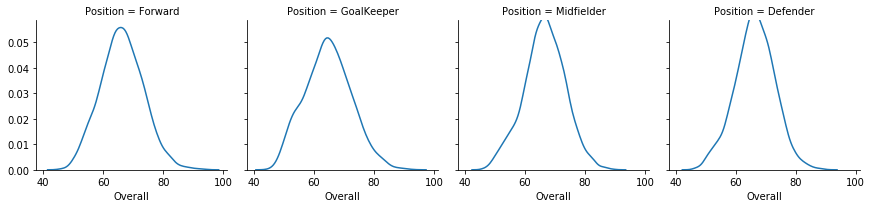

In [66]:
df = fifa

g = sns.FacetGrid(df, col="Position", col_wrap=6)
classes_fifa = fifa
g.map(sns.kdeplot, "Overall")

This plot represents the spread of various players' Overall Stat across the different categories of forward, goalkeeper, midfielder and defender. It gives an idea of the lowest rated player and highest rated player across the different categories.

Next, to determine the features that best influence in categorizing of groups, we can split the four categories of players into two for analysis. Forwards, midfielders and defenders are grouped together as Outfield players while the Goalkeepers are kept separately for analysis.

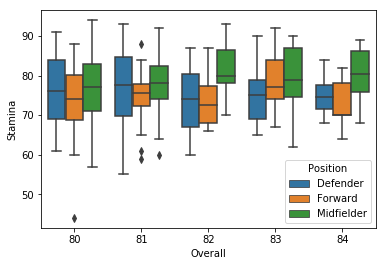

In [65]:
f = (fifa
         .loc[fifa['Position'].isin(['Forward', 'Midfielder','Defender'])]
         .loc[:, [ 'Overall', 'Stamina', 'Position']]
    )
f = f[f["Overall"] >= 80]
f = f[f["Overall"] < 85]
f['Stamina'] = f['Stamina'].astype(float)

test_data = data
test_labels = labels

sns.boxplot(x="Overall", y="Stamina", hue='Position', data=f)

The boxplot shows which position requires the maximum usage of stamina. So this can be used as a major factor that influences the categorisation. It is clear the plot that, the midfielders are require the most stamina then will be defenders and finally the forwards.

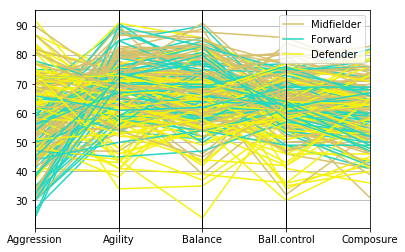

In [45]:
from pandas.plotting import parallel_coordinates

f = (
    fifa.iloc[:, 5:10]
        .loc[fifa['Position'].isin(['Forward', 'Midfielder','Defender'])]
)
f['Position'] = fifa['Position']
f = f.sample(200)

parallel_coordinates(f, 'Position')

This multivariate plot shows the impact of other features than may have role in defining the classification criteria. We can infer the defenders have considerably low values for features like Agility, Composure, Curve, Dribbling and Finishing. These factors are very high for Forwards and just as expected moderate for midfielders. This only affirms our initial hypothesis.

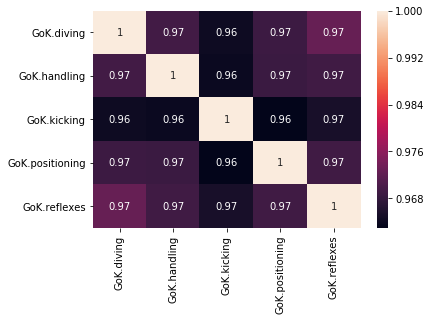

In [19]:
f = (
    fifa.loc[:, ['GoK.diving', 'GoK.handling', 'GoK.kicking', 'GoK.positioning','GoK.reflexes']]
).corr()

sns.heatmap(f, annot=True)

Now that we have got some clear picture about the outfield players, this heatmap can be used solely for the purpose of evalating the goalkeeper features. The five features of Diving, Handling, kicking, positioning and reflexes. These features tend to have a higher values only if the player is categorised as a goalkeeper, which is obvious. This visualisation is just to make strong claim to the hypothesis we made.

## Methods

### Summary of Neural Networks

Neural Network is a technique for building a computer program that learns from data. It is loosly based on how a human brain computes. First, a collection of software “neurons” are created and connected together, allowing them to send messages to each other. Next, the network is asked to solve a problem, which learns by tring to solve it again and again irrespective if the attempt is a success or a failure, instead it strengthens the connections whenever it succeeds and diminishes them if it ends up as a failure.

A simple worjing of a neural network can be described as follows. It has a set of inputs x1,x2,...xn with their corresponding weights w1,w2,....wn. These when fed into an preceptron, which is technically a neuron, the weighted sum of all the averages z = w^t.x is calculated. This weightsum is passedthrough a stepped function that has a threshold value and based on that value it gives an predictive output h(x) = step(w^t.x).

By connecting the perceptrons, we can actually build synaptic connections. This model is called as multi-layer perceptron (MLP).

### Summary of Nonlinear Logistic Regression

A linear logistic regression can be attained by one single layer of neural network. But incase when our models tend to have non-linear relationship between the dependent and independent parameters ie. when there are no line of best fit when we are plotting our data.

For a linear model, the softmax function is given as follows:

$$
g_k(x) = P(T=k \mid x) = \frac{e^{\kappa_k}}{\sum_{c=1}^K e^{\kappa_c}}
$$

And similarly the error function is given as,

$$
E(w) = - \ln P(T \mid w) =  - \sum_{n=1}^{N} \sum_{k=1}^{K} t_{n,k} \ln y_{n,k}.
$$

Starting from these we can derive the non-linear models by simply extending this to two layer neural networks. We can also derive the gradient by switching the squuared error with the negative log likelihood function above.

$$
\frac{\partial{E}}{\partial{v_{dg}}} = -\sum_{n=1}^{N} \Big( t_{n,k^\prime} - g_{nk^\prime}(x_n) \Big) z1_{nk^\prime}.
$$


Coverting this gradient in matrix form and reflecting it on our weight update,

$$
W \leftarrow W + \alpha_o Zl^\top \Big(  T - g(X)\Big).
$$


### Implementation of Nonlinear Logistic Regression

In [8]:
class Standardizer: 

    def __init__(self, X, explore=False):
        self._mu = np.mean(X,0)  
        self._sigma = np.std(X,0)
        if explore:
            print ("mean: ", self._mu)
            print ("sigma: ", self._sigma)
            print ("min: ", np.min(X,0))
            print ("max: ", np.max(X,0))

    def set_sigma(self, s):
        self._sigma[:] = s

    def standardize(self,X):
        return (X - self._mu) / self._sigma 

    def unstandardize(self,X):
        return (X * self._sigma) + self._mu 

In [30]:
from nn import NeuralNet

class NeuralNetLogReg(NeuralNet):

    def __init__(self, nunits):
        
        self._nLayers=len(nunits)-1
        self.rho = [1] * self._nLayers
        self._W = []
        self.wdims = []
        self.lenweights = 0
        for i in range(self._nLayers):
            nwr = nunits[i] + 1
            nwc = nunits[i+1]
            self.wdims.append((nwr, nwc))
            self.lenweights = self.lenweights + nwr * nwc

        self._weights = np.random.uniform(-0.1,0.1, self.lenweights) 
        start = 0 
        for i in range(self._nLayers):
            end = start + self.wdims[i][0] * self.wdims[i][1] 
            self._W.append(self._weights[start:end])
            self._W[i].resize(self.wdims[i])
            start = end
        
        self.stdX = None
        self.stdT = None
        self.stdTarget = True
        self.numOfSamples = 0

    def softmax(self,z):
        if not isinstance(z, np.ndarray):
            z = np.asarray(z)
        f = np.exp(z)
        return f / (np.sum(f, axis=1, keepdims=True) if len(z.shape) == 2 else np.sum(f))

    def forward(self, X):
        self.numOfSamples = X.shape[0]
        t = X 
        Z = []

        for i in range(self._nLayers):
            Z.append(t) 
            if i == self._nLayers - 1:
                t = self.softmax(np.dot(NeuralNet.add_ones(self,t), self._W[i]))
            else:
                t = np.tanh(np.dot(NeuralNet.add_ones(self,t), self._W[i]))
        return t, Z

    def _objectf(self, T, Y, wpen):
        E = - np.sum(np.multiply(T, np.log(Y)) + np.multiply((1-T), np.log(1-Y))) + wpen
        #E = -1 * np.sum(np.sum(np.multiply(T, np.log(Y)), axis = 0)) - wpen
        return E
        
    def train(self, X, T, **params):
        #pd.value_counts(TtrainClass1.values.flatten())
        T = T.flatten()
        di = pd.get_dummies(T)
        indicatorMatrix = di.values
        NeuralNet.train(self, X, indicatorMatrix, **params)

    def use(self, X):
        
        self.stdX = Standardizer(X)
        Xs = self.stdX.standardize(X)
        
        Y, Z = self.forward(Xs)
        Classes = np.argmax(Y, 1)
        return Classes, Y



The class has various functions like train, use, objectf, softmax and forward. The _init_ initalised all the ncessary paramters for the neural network like the number of neurons, leanrning rate, weights etc. Once the values are initialed, the neural network makes use of the softmax function during the forward propagation to train the neural network based on the data provided to it. The objectf function is the error optimization function.

Once the training is complete, we can the use function gives the standardised predictions. In this case, tjhe classification results of the players are categorised is given as the output.

### Priliminary Testing and Code Examination

Before, we can implement the Non linear regression model on our data, we can first test it with a sample data. We can experiment and examine how well our algorithm works efficiently.

Text(0.5,1,'test data set')

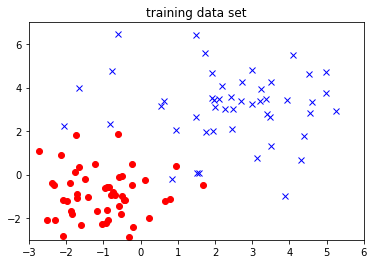

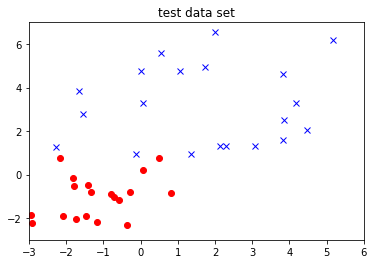

In [31]:
# Data for testing
N1 = 50
N2 = 50
N = N1 + N2
D = 2
K = 2

mu1 = [-1, -1]
cov1 = np.eye(2)

mu2 = [2,3]
cov2 = np.eye(2) * 3

#
#  Train Data
#
C1 = np.random.multivariate_normal(mu1, cov1, N1)
C2 = np.random.multivariate_normal(mu2, cov2, N2)

plt.plot(C1[:, 0], C1[:, 1], 'or')
plt.plot(C2[:, 0], C2[:, 1], 'xb')

plt.xlim([-3, 6])
plt.ylim([-3, 7])
plt.title("training data set")

Xtrain = np.vstack((C1, C2))
Ttrain = np.zeros((N, 1))
Ttrain[50:, :] = 1  # labels are zero or one

means, stds = np.mean(Xtrain, 0), np.std(Xtrain, 0)
# normalize inputs
Xtrains = (Xtrain - means) / stds

#
#  Test Data
#
Ct1 = np.random.multivariate_normal(mu1, cov1, 20)
Ct2 = np.random.multivariate_normal(mu2, cov2, 20)

Xtest = np.vstack((Ct1, Ct2))
Ttest = np.zeros((40, 1))
Ttest[20:, :] = 1

# normalize inputs
Xtests = (Xtrain - means) / stds


plt.figure()
plt.plot(Ct1[:, 0], Ct1[:, 1], 'or')
plt.plot(Ct2[:, 0], Ct2[:, 1], 'xb')

plt.xlim([-3, 6])
plt.ylim([-3, 7])
plt.title("test data set")

In [32]:
clsf = NeuralNetLogReg([2, 4, 2])
clsf.train(Xtrain, Ttrain)
classes, Y = clsf.use(Xtest)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in multiply


In [33]:
classes

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=int64)

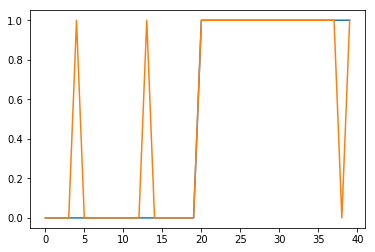

In [34]:
plt.plot(Ttest)
plt.plot(classes)


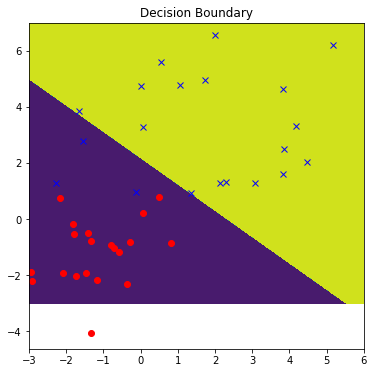

In [35]:
# show me the boundary

x = np.linspace(-3, 6, 1000)
y = np.linspace(-3, 7, 1000)

xs, ys = np.meshgrid(x, y)

X = np.vstack((xs.flat, ys.flat)).T
classes, _ = clsf.use(X)
zs = classes.reshape(xs.shape)

plt.figure(figsize=(6,6))
plt.contourf(xs, ys, zs.reshape(xs.shape))
plt.title("Decision Boundary")

plt.plot(Ct1[:, 0], Ct1[:, 1], 'or')
plt.plot(Ct2[:, 0], Ct2[:, 1], 'xb')

As we can see, we get a very good classificatio result for this model. There are some errors while but we have an optimal accuracy of 83% which is not bad of an achievement.

We can further check the efficiency and the accuracy for our classification algorithm by the method of cross validation.

### Cross Validation

Cross validation allows us to choose the best parameters so that our model can generate results with the highest possible accuracies. Here given is the implementation of the cross validation function.

In [52]:
from sklearn.metrics import accuracy_score

In [76]:
def k_fold_cross_method(XPartition, TPartition):

    accuracy = []
    finalAccuracy=[]
    parameterList= []
    finalParam = []

    partX = np.array_split(XPartition,5)
    partT = np.array_split(TPartition,5)
    
    for test in range(5):
        Xtest = partX[test]
        Ttest = partT[test]

        for val in range (5):
            if (test != val):
                
                Xval = partX[val]
                Tval = partT[val]

                Xtrain = np.asarray([])
                Ttrain = np.asarray([])

                for i in range(5):
                    if (i != val and i != test):
                        if Ttrain.size == 0:
                            Xtrain = partX[i]
                            Ttrain = partT[i]
                        else:
                            Xtrain = np.concatenate((Xtrain, partX[i]),axis = 0)
                            Ttrain = np.concatenate((Ttrain, partT[i]),axis = 0)

                input_size = Xtrain.shape[1]
                paramsModel = [[input_size,2,2],[input_size,3,2],[input_size,4,2],[input_size,5,2],[input_size,6,2]]
                for l in paramsModel:
                    Model = NeuralNetLogReg(l)
                    Model.train(Xtrain, Ttrain)
                    y_pred, class_predict = Model.use(Xval)
                    acc = accuracy_score(Tval, y_pred)
                    accuracy.append(acc)
                    parameterList.append(l)
                
        bestParamIndex = np.argmax(accuracy)
        bestParam = parameterList[bestParamIndex]

        XtrainF = np.asarray([])
        TtrainF = np.asarray([])           
        for i in range(5):
            if (i != test):
                if TtrainF.size == 0:
                    XtrainF = partX[i]
                    TtrainF = partT[i]
                else:
                    XtrainF = np.concatenate((XtrainF, partX[i]), axis = 0)
                    TtrainF = np.concatenate((TtrainF, partT[i]), axis = 0)

        BestModel = NeuralNetLogReg(bestParam)
        BestModel.train(XtrainF, TtrainF)
        finalPredection, finalPred = BestModel.use(Xtest) 
        accurate = accuracy_score(Ttest,finalPredection)
        finalParam.append(bestParam)
        finalAccuracy.append(accurate)
        
    return finalAccuracy, finalParam


In [77]:
Accuracies , Parameters = k_fold_cross_method(Xtrain, Ttrain)
print(Accuracies, 'best accuracies')
print(Parameters, 'best params')

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log
c:\users\my pc\grad.py:128: RuntimeWarning: invalid value encountered in double_scalars
  Delta = 2. * (fnew - fold) / (alpha*mu)
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in multiply
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp


[0.34999999999999998, 0.29999999999999999, 1.0, 0.5, 0.5] best accuracies
[[2, 6, 2], [2, 6, 2], [2, 6, 2], [2, 6, 2], [2, 6, 2]] best params


## Results

### Visualisations

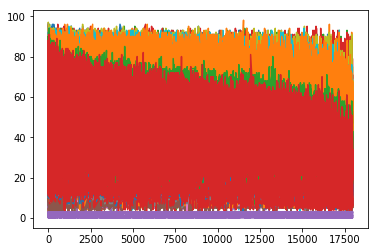

In [64]:
#classifier for Non-linear Logistic model

plt.plot(test_data)
plt.plot(test_labels)

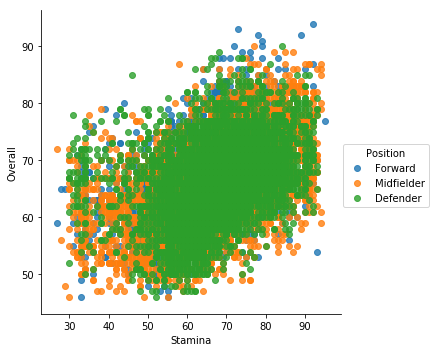

In [69]:
import seaborn as sns

sns.lmplot(x='Stamina', y='Overall', hue='Position', 
           data=classes_fifa.loc[fifa['Position'].isin(['Forward','Midfielder','Defender'])], 
           fit_reg=False)

This plots show the distribution of various categories of players predicted by the non linear regression model. It maynot have the best of accuracies while classification it still provides an acceptable prediction

### Choice of Parameters and Network Structure

The parameters chosen is [Xtrain.shape[2],6,2]. As the cross validation states we get maximum accuracy from this paramters, we choose it 

### Classification Model Comparison

In [37]:
import numpy as np
import abc
from abc import ABC, abstractmethod
# Super class for machine learning models 

class BaseModel(ABC):
    """ Super class for ITCS Machine Learning Class"""
    
    @abstractmethod
    def train(self, X, T):
        pass

    @abstractmethod
    def use(self, X):
        pass

    

class Classifier(BaseModel):
    """
        Abstract class for classification 
        
        Attributes
        ==========
        meanX       ndarray
                    mean of inputs (from standardization)
        stdX        ndarray
                    standard deviation of inputs (standardization)
    """

    def __init__(self, ):
        self.meanX = None
        self.stdX = None

    def normalize(self, X):
        """ standardize the input X """
        
        if not isinstance(X, np.ndarray):
            X = np.asanyarray(X)

        self.meanX = np.mean(X, 0)
        self.stdX = np.std(X, 0)

        Xs = (X - self.meanX) / self.stdX
        return Xs

    def _check_matrix(self, mat, name):
        if len(mat.shape) != 2:
            raise ValueError(''.join(["Wrong matrix ", name]))
        
    # add a basis
    def add_ones(self, X):
        """
            add a column basis to X input matrix
        """
        self._check_matrix(X, 'X')
        return np.hstack((np.ones((X.shape[0], 1)), X))

    ####################################################
    #### abstract funcitons ############################
    @abc.abstractmethod
    def train(self, X, T):
        pass
    from abc import ABC, abstractmethod
    @abc.abstractmethod
    def use(self, X):
        pass 

In [38]:
class QDA(Classifier):

    def __init__(self):
        Classifier.__init__(self)
        self.mu1 = None
        self.mu2 = None
        self.Sigma1 = None
        self.sigma2 = None
        self.prior1 = None
        self.prior2 = None
        
    def QDA(self, X, mu, sigma, prior):
        sigma_inv = np.linalg.inv(sigma)
        diffv = X - mu
        return -0.5  * np.log(np.linalg.det(sigma))- 0.5 * np.sum(diffv @ sigma_inv * diffv, axis=1) + np.log(prior)

    def div(self,X,T):
        c1 = []
        c2 = []
        for i in range(len(T)):
            if T[i] == 1:
                c1.append(X[i,:])
            else:
                c2.append(X[i,:])
        return c1,c2
    
    def prediction(self,d1,d2):
        y = []
        for i in range(len(d1)):
            if(d1[i]>d2[i]):
                y.append([-1])
            else:
                y.append([1])
        return y
     
    def train(self, X, T):
        X = self.normalize(X)
        a = np.array([])
        b = np.array([])
        a,b = self.div(X,T)
        a = np.array(a)
        b = np.array(b)
        
        self.mu1 = np.mean(a, 0)
        self.mu2 = np.mean(b, 0)

        self.Sigma1 = np.cov(a.T)
        self.Sigma2 = np.cov(b.T)

        N = X.shape[0]
        self.prior1 = a.shape[0] / N
        self.prior2 = b.shape[0] / N
        pass
    
    def use(self, X):
        X = self.normalize(X)
        d1 = self.QDA(X, self.mu1, self.Sigma1, self.prior1)
        d2 = self.QDA(X, self.mu2, self.Sigma2, self.prior2)
        Y = self.prediction(d1,d2)
        return Y
        pass 

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Ttrain,Y)

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


features_train, features_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.3, random_state=42)

rnd_clf = RandomForestClassifier(n_estimators = 500,criterion = 'entropy', min_samples_split = 2,min_samples_leaf = 5, max_depth=20)
rnd_clf.fit(features_train, labels_train)
pred = rnd_clf.predict(features_test)
print(accuracy_score(labels_test,pred))
target_names = ['goalkeeper', 'defender', 'midfielder','forward']
print(classification_report(labels_test,pred, target_names = target_names))

0.833070866142
             precision    recall  f1-score   support

 goalkeeper       1.00      1.00      1.00       557
   defender       0.85      0.88      0.86      1555
 midfielder       0.78      0.81      0.80      2036
    forward       0.81      0.71      0.76       932

avg / total       0.83      0.83      0.83      5080



Comparning the metrics, we can see the non-linear logistic regression model, provides a better accuracy the random classifier we have used here.

## Conclusion

Thus throught his assignment, I have got a thorough knowledge of how to implement the non-linear logistic model with the use of neural networks. I have also compared this with the classifiers like QDA and randoforest classifiers and have come to the inference that the usage of neural networks provide great results when compared to the ones that doesn't use it.